# Imports and Downloads

In [1]:
#download pretty midi library for midi files
!pip install pretty_midi

In [2]:
# download langdetect library for language detection
!pip install langdetect

In [3]:
# language detection library
from langdetect import detect

In [4]:
# midi exploration libraries
import pretty_midi
import librosa.display

In [5]:
# general libraries
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import string

In [6]:
# deep learning libraries - tensorflow environment
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Input, Reshape, Add, Multiply, Flatten
from keras.models import Model
import datetime

In [7]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [8]:
# word embedding libraries
import gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

In [9]:
# sklearn libraries
from sklearn.model_selection import train_test_split

# Mount Google Drive

In [10]:
# mount google drive to get required files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

### Load midi files

In [11]:
def split_path(file_path):
  """
  splits path into singer and song name
  """
  try:
    path_splitted = file_path.lower().replace('_',' ').replace('.mid','').split(' - ')
    singer, song_name = path_splitted[0], path_splitted[1]
  except:
    print(file_path)
  return singer, song_name

In [12]:
# load midi files
def get_midi_file(midi_path):
  """
  returns pretty midi object of the midi path
  """
  try: 
    return pretty_midi.PrettyMIDI(midi_path)
  except Exception as e:
    return None

In [13]:
def get_all_midi_files(midi_folder):
  """
  returns midi_data dict and corrupted_data list.
  midi_data contains tuple keys of singer and song name and value of pretty midi object
  corrupted_data contains singer and song name tuples of corrupted midi files. 
  """
  midi_data = {}
  corrupted_data = []
  
  for midi_file_path in os.listdir(midi_folder):
    singer, song_name = split_path(midi_file_path)
    midi_file_object = get_midi_file(os.path.join(midi_folder, midi_file_path))

    # if midi file have problems
    if midi_file_object is None:
      corrupted_data.append((singer,song_name))
    
    else:
      midi_data[(singer, song_name)] = midi_file_object
  
  print(f'Corrupted data: {len(corrupted_data)}')
  print(corrupted_data)
  print(f'midi_data:{len(midi_data)}')
  
  return midi_data, corrupted_data

In [14]:
# run midi files loading
midi_files_folder = 'drive/MyDrive/DeepLearningAssignment3/midi_files'
start = time.time()
midi_data, corrupted_data = get_all_midi_files(midi_files_folder)
end = time.time() - start
print(f"Total time: {end}")

Corrupted data: 7
[('dan fogelberg', 'leader of the band'), ('beastie boys', 'girls'), ('billy joel', "movin' out"), ('david bowie', 'lazarus'), ('billy joel', 'pressure'), ('brian mcknight', 'on the down low'), ('aaron neville', 'tell it like it is')]
midi_data:618
Total time: 108.20950675010681


### Load csv files

In [15]:
# load csv files
def load_csv_file(csv_path):
  """
  creates dataframe of three columns singer, song name, lyrics.
  row with more than one song splits into number of songs while the singer is same but song name and 
  lyrics different - in this case appends one more row for the other songs
  """

  data = pd.read_csv(csv_path, header=None)
  df = pd.DataFrame(columns=['singer', 'song_name', 'lyrics'])

  for i in range(1, data.shape[1], 2):
    data_df = data.iloc[:, [0, i, i+1]]
    data_df = data_df[data_df.iloc[:,1].notna()]

    new_cols = {x:y for x,y in zip(data_df.columns, df.columns)}
    df = pd.concat([df, data_df.rename(columns=new_cols)])
  
  return df

In [16]:
# run csv loading
train_path = 'drive/MyDrive/DeepLearningAssignment3/lyrics_train_set.csv'
test_path = 'drive/MyDrive/DeepLearningAssignment3/lyrics_test_set.csv'
train_df = load_csv_file(train_path)
test_df = load_csv_file(test_path)

# Exploration

### Explore csv files

In [17]:
# explore csv files

print(f"Num of singer: {len(train_df['singer'].unique())}")
print(f"Num of songs: {len(train_df['song_name'].unique())} \n")
duplic = train_df.duplicated(subset=["singer", "song_name", "lyrics"])
print(f"Num of duplicated songs: {len(train_df[duplic])}")
print(f"{train_df[duplic].iloc[:][['singer','song_name']]} \n")

print(f"Num of covers: {len(train_df[(train_df['lyrics'].duplicated()) ^ (duplic)])}")
print(f"{train_df[(train_df['lyrics'].duplicated()) ^ (duplic)][['singer','song_name']]} \n")

long_singer, long_song = train_df[train_df['lyrics'].map(len) == train_df['lyrics'].map(len).max()].iloc[0][['singer','song_name']]
long_length = train_df['lyrics'].str.split(" ").map(len).max()
print(f"Longest song: {long_song} by {long_singer}. Song length {long_length} \n")

short_singer, short_song = train_df[train_df['lyrics'].map(len) == train_df['lyrics'].map(len).min()].iloc[0][['singer','song_name']]
short_length = train_df['lyrics'].str.split(" ").map(len).min()
print(f"Shortest song: {short_song} by {short_singer}. Song length {short_length} \n")


songs_different_words = train_df['lyrics'].str.split(" ").map(set).map(len)
songs_different_words_list = list(songs_different_words)
songs_different_words_list.sort()
print(f'Songs total different words:\n{songs_different_words_list}\n')

shortest_songs = train_df[songs_different_words <= 20 ]
print(f'Songs with less than 20 different words:\n{shortest_songs}')

Num of singer: 226
Num of songs: 606 

Num of duplicated songs: 2
           singer          song_name
178     all 4 one            i swear
271  depeche mode  enjoy the silence 

Num of covers: 3
          singer       song_name
220  eric carmen   all by myself
406        bread    goodbye girl
550      boyzone  picture of you 

Longest song: stan by eminem. Song length 1481 

Shortest song: sandstorm by darude. Song length 14 

Songs total different words:
[4, 6, 8, 10, 12, 12, 15, 18, 22, 32, 34, 34, 35, 37, 37, 38, 39, 39, 41, 42, 42, 43, 43, 43, 44, 44, 46, 47, 47, 48, 48, 48, 49, 49, 49, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 53, 53, 54, 54, 54, 55, 55, 55, 56, 56, 56, 56, 56, 57, 57, 57, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 6

In [18]:
train_df['lyrics'].str.split(" ").map(set)

0      {but, was, played, to, you, monroe, say, in, r...
1      {lite, but, was, to, booze, been, you, about, ...
2      {was, to, lean, through, mind, been, line, you...
3      {but, was, to, temperature, offense, you, is, ...
4      {which, preach, to, through, line, you, in, is...
                             ...                        
446    {high, but, texas, at, pull, sun, along, dime,...
483    {but, to, live, you, want, in, is, car, talk, ...
487    {hide, keeps, people, but, at, it, when, alrig...
569    {wait, to, been, you, want, in, is, let, oh, f...
132    {but, was, to, line, you, about, want, in, nig...
Name: lyrics, Length: 615, dtype: object

In [19]:
all_lyrics_list = train_df['lyrics'].str.split().map(lambda x : set(x)).values
unique_words = list(set(set().union(*all_lyrics_list)))
unique_words.sort()
unique_words

['!',
 '"sonny',
 '#',
 '##',
 '&',
 '&702',
 '&abba',
 '&backstreet',
 '&bee',
 '&billy',
 '&britney',
 '&buck',
 '&cat',
 '&chaka',
 '&david',
 '&george',
 "'",
 "''cause",
 "'53",
 "'64",
 "'65",
 "'75",
 "'a'",
 "'ay-yo",
 "'b'",
 "'bout",
 "'cause",
 "'cid",
 "'cos",
 "'coz",
 "'cross",
 "'cuz",
 "'dro",
 "'em",
 "'em.",
 "'er",
 "'ers",
 "'ey",
 "'fore",
 "'friend'",
 "'gators",
 "'hell-ier'",
 "'it",
 "'jesus",
 "'kid",
 "'most",
 "'n'",
 "'neath",
 "'please",
 "'relax'",
 "'round",
 "'round's",
 "'s",
 "'spect",
 "'sticking",
 "'stop",
 "'t",
 "'this",
 "'though",
 "'til",
 "'till",
 "'way",
 "'we",
 "'ya?",
 '(',
 "('cause",
 "('till",
 '(*)',
 '(2x)',
 '(`n',
 '(a',
 '(a-ha)',
 '(aah)',
 '(aaron)',
 '(abacab)',
 '(add',
 '(again',
 '(again)',
 '(ah',
 '(ah!)',
 '(aha',
 '(ahh!)',
 '(all',
 '(alright)',
 '(always)',
 '(and',
 '(any',
 '(anywhere',
 "(aren't",
 '(argh!)',
 '(as',
 '(awright',
 '(baby',
 '(baby)',
 '(bad',
 '(bang!)',
 '(be',
 '(beat',
 '(before',
 '(better',
 '

### Explore midi files

In [20]:
# midi files exploration
for midi_object in midi_data.values():
  print('There are {} time signature changes'.format(len(midi_object.time_signature_changes)))
  print('There are {} instruments'.format(len(midi_object.instruments)))
  print('Instrument 3 has {} notes'.format(len(midi_object.instruments[0].notes)))
  print('Instrument 4 has {} pitch bends'.format(len(midi_object.instruments[4].pitch_bends)))
  print('Instrument 5 has {} control changes'.format(len(midi_object.instruments[5].control_changes)))
  print(midi_object.key_signature_changes)
  print(midi_object.instruments)
  print(midi_object.instruments[0].notes)
  print(midi_object.instruments[0].pitch_bends)
  print(midi_object.instruments[0].control_changes)
  # plt.figure(figsize=(8, 4))
  # plot_piano_roll(midi_object, 24, 84)
  break

There are 1 time signature changes
There are 10 instruments
Instrument 3 has 2698 notes
Instrument 4 has 0 pitch bends
Instrument 5 has 2 control changes
[KeySignature(key_number=0, time=0.0)]
[Instrument(program=27, is_drum=False, name="guitar"), Instrument(program=30, is_drum=False, name="guitar"), Instrument(program=33, is_drum=False, name="guitar"), Instrument(program=29, is_drum=False, name="guitar"), Instrument(program=33, is_drum=False, name="bass"), Instrument(program=84, is_drum=False, name="synth"), Instrument(program=84, is_drum=False, name="synth"), Instrument(program=119, is_drum=False, name="cymbal"), Instrument(program=50, is_drum=False, name="synth"), Instrument(program=0, is_drum=True, name="drums")]
[Note(start=1.371428, end=1.542856, pitch=44, velocity=127), Note(start=1.371428, end=1.542856, pitch=32, velocity=127), Note(start=1.542856, end=1.714285, pitch=32, velocity=127), Note(start=1.542856, end=1.714285, pitch=44, velocity=127), Note(start=1.714285, end=1.88571

In [21]:
for midi_object in midi_data.values():
  """
  Test instrument program, and pitches
  """
  a = list(set([x.pitch for x in midi_object.instruments[0].notes]))
  b = list(set([x.program for x in midi_object.instruments]))
  print(a)
  print(b)
  break

[32, 35, 39, 40, 42, 44, 47, 54, 56, 27, 28, 30]
[0, 33, 50, 84, 119, 27, 29, 30]


# Pre processing

### Drop duplicates

In [22]:
# drop duplicated rows and covers (=same song lyrics but different singer) 
train_df.drop_duplicates(inplace=True)
train_df = train_df[~(train_df['lyrics'].duplicated()) ^ (train_df.duplicated())]
train_df.reset_index(inplace=True, drop=True)

### Remove corrupted midi songs

In [23]:
# drop songs with corrupted midi files
corrupted_songs_indices_train = []
corrupted_songs_indices_test = []
for artist, song, in corrupted_data:
  try:
    # get index of corrupted song
    index = train_df[(train_df['artist'] == artist) & (train_df['song'] == song)].index[0]
    corrupted_songs_indices_train.append(index)

  # if song doesn't exist in train set chec if exist in test set
  except:
    try:
      index = test_df[(test_df['artist'] == artist) & (test_df['song'] == song)].index[0]
      corrupted_songs_indices_test.append(index)
      
    # if song doesn't exist in train and test sets
    except:
      print(f"{artist}, {song} -  Song does not exist.")
      
train_df.drop(index=corrupted_songs_indices_train).reset_index(drop=True, inplace=True)
test_df.drop(index=corrupted_songs_indices_test).reset_index(drop=True, inplace=True)

dan fogelberg, leader of the band -  Song does not exist.
beastie boys, girls -  Song does not exist.
billy joel, movin' out -  Song does not exist.
david bowie, lazarus -  Song does not exist.
billy joel, pressure -  Song does not exist.
brian mcknight, on the down low -  Song does not exist.
aaron neville, tell it like it is -  Song does not exist.


### Drop non-english songs

In [24]:
# detect non english songs using langdetect libeary
detect_non_english_songs = []
for i in range(0, train_df.shape[0]):
  if detect(train_df['lyrics'].iloc[i]) != 'en':
    detect_non_english_songs.append(i)
detect_non_english_songs

[187, 188, 190, 221, 302, 361]

In [25]:
# half english and half spanish song - found after exploration
train_df.iloc[220].lyrics # remove spanglish

"(esta noche bailamos) & (te doy toda mi vida) & (quã©date conmigo) & tonight we dance & i leave my life in your hands & we take the floor & nothing is forbidden anymore & don't let the world dim my sight & don't let a moment go by & nothing can stop us tonight & bailamos let the rhythm take you over & bailamos & te quiero amor mã\xado bailamos & gonna live this night forever & bailamos & te quiero amor mã\xado te quiero & tonight i'm yours & we can make it happen i'm so sure & now i'm letting go & there is something i think you should know & i won't be leaving your side & we're gonna dance through the night & i'm gonna reach for the stars & bailamos let the rhythm take you over & bailamos & te quiero amor mã\xado bailamos & gonna live this night forever & bailamos & te quiero amor mã\xado te quiero & (whoa oh oh oh) tonight we dance & (whoa oh oh oh) like no tomorrow & (whoa oh oh oh) if you will stay with me & te quiero mi amor & (quã©date conmigo) & (esta noche) & bailamos let the r

In [26]:
# remove non english songs after verification - we were looking on each song's lyrics
non_english_songs = [187,188,220, 221,302, 361]
train_df.drop(index=non_english_songs, inplace=True)
train_df.reset_index(drop=True, inplace=True)
train_df

,singer,song_name,lyrics
0,elton john,candle in the wind,goodbye norma jean & though i never knew you a...
1,gerry rafferty,baker street,winding your way down on baker street & lite i...
2,gerry rafferty,right down the line,you know i need your love & you've got that ho...
3,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...
4,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...
...,...,...,...
599,george strait,amarillo by morning,amarillo by mornin' & up from san antone & eve...
600,ace of base,all i have to give,i don't know what he does to make you cry & bu...
601,backstreet boys,larger than life,i may run and hide & when you're screamin' my ...
602,bee gees,i just want to be your everything,for so long & you and me been finding each oth...


### Remove unnecessary [word] regex

In [27]:
# clean text:
# 1. change last word into eof word
# 2. remove unnecessary spaces
# 3. remove ' from words like i'll
# 4. remove [] and words between them
# 5. remove extra &
for index, row in train_df.iterrows():
  # if '[' in row.lyrics:
  splitted_row = row.lyrics.split()
  splitted_row[-1] = 'eof'
  filtered_row = " ".join(splitted_row) # remove unnecessary spaces
  # filtered_row = filtered_row.replace("'","")
  filtered_row = " ".join(filter(lambda x:x[0]!='[', filtered_row.split()))
  filtered_row = " ".join(filter(lambda x:x[-1]!=']', filtered_row.split()))
  filtered_row = " ".join([word for word in filtered_row.split() if not (len(word)>1 and word[0]=='&' )]) # remove words starts with & 

  while '& &' in filtered_row:
      filtered_row = filtered_row.replace("& &","&")

  train_df.iloc[index].lyrics = filtered_row

In [28]:
# Test if extra & stil exists - should be empty
for index, row in train_df.iterrows():
  if '& &' in row.lyrics or '[' in row.lyrics or ']' in row.lyrics:
    print(index)

### Tokenization

In [29]:
# tokenize lyrics and transform lyrics into sequences of tokens
tokenizer = Tokenizer(filters='1234567890!",#$%()*+-./:;<=>?@[\\]^_`{|}~\t\n')  # delete & from filters
tokenizer.fit_on_texts(train_df['lyrics'])
vocab_size = len(tokenizer.word_index) + 1
sequences_texts = tokenizer.texts_to_sequences(train_df['lyrics'])

# GloVe

In [30]:
# download 
if 'glove.6B.zip' not in os.listdir():
  !wget http://nlp.stanford.edu/data/glove.6B.zip
  !unzip -q glove.6B.zip

In [31]:
# load glove embedding 
path_to_glove_file =  "glove.6B.300d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [32]:
def get_embedding(embedding_dim):
  """
  returns embedding matrix of shape vocab_size on embedding dim
  """
  vocabulary_size=len(tokenizer.word_index)+1
  embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
  missing_words = []

  # Prepare embedding matrix
  for word, i in tokenizer.word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
      else:
          # if word doesn't have embedded representation - generate new vector with normal dist values
          missing_words.append(word)
          embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), embedding_dim)
  
  print(f"Total missing words: {len(missing_words)}")
  return embedding_matrix

In [33]:
# run ebedding and remove unnecessary index
embedding_matrix = get_embedding(300)
del(embeddings_index)

Total missing words: 752


# Split train and validation

In [34]:
def split_train_test(x, y):
  """
  splits data into train and validation sets - 90 % train, 10% validation
  """
  X_train, X_val, y_train, y_val = train_test_split(x,y, train_size = 0.9, random_state=42)
  return X_train, X_val, y_train, y_val

# Midi version 1

### Concatenate lyrics and midi dataframes

In [35]:
def get_midi_beats(t):
  """
  Returns beats of the given song t - t is a tuple of (singer, song_name)
  """
  singer, song_name = t[0].lower().strip(), t[1].lower().strip()
  if (singer, song_name) in midi_data:
    return midi_data[(singer, song_name)].get_beats()
  else:
    return None

In [36]:
# add beats column to dataframe
train_df["beats"] = train_df.apply(get_midi_beats, axis=1)
test_df["beats"] = test_df.apply(get_midi_beats, axis=1)

In [37]:
# remove songs without beats from sequences
indexes = list(train_df[train_df["beats"].isna()].index)
for index in sorted(indexes, reverse=True):
    del sequences_texts[index]

In [38]:
# remove songs wout midi beats from dataframe
train_df = train_df[~train_df["beats"].isna()]
test_df = test_df[~test_df["beats"].isna()]

In [39]:
# reset indices after deletion 
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

### Text sequences

In [40]:
def get_lyrics_and_beats_sequences(df, lyrics_seq_length, beats_seq_length):
  """
  Returns lyrics and beats sequences
  """
  lyrics_sequences = []
  beats_sequences = []

  # iterate through every song
  for index, sample in enumerate(sequences_texts):
    lyrics = sample # a list of all the tokens in the song lyrics
    beats = df.iloc[index]["beats"].tolist() # a list of all the beats times in the song

    # iterate through the song's lyrics
    for i in range(lyrics_seq_length, len(lyrics)):
      lyrics_sequence = lyrics[i-lyrics_seq_length:i]
      lyrics_sequences.append(lyrics_sequence)

      # get the beats relational to the lyrics sequence position
      lyrics_seq_start_ind = i-lyrics_seq_length
      lyrics_length = len(lyrics)
      beats_length = len(beats)
      # calculate the beats relational indices
      beats_start_ind = int((lyrics_seq_start_ind / lyrics_length) * beats_length)
      # check if not end of beats
      beats_start_ind = beats_start_ind if beats_start_ind + beats_seq_length < beats_length else beats_length - beats_seq_length-1
      beats_end_ind = beats_start_ind + beats_seq_length
      # check if not the end of beats
      beats_end_ind = beats_end_ind if beats_end_ind < beats_length else beats_length - 1

      # append to the beats sequences list
      beats_sequence = beats[beats_start_ind:beats_end_ind]
      beats_sequences.append(beats_sequence)
  
  # check if there were bad beats sequences
  for x in beats_sequences:
    if len(x) < beats_seq_length:
      print(x)
  
  return np.array(lyrics_sequences), np.array(beats_sequences)

In [41]:
lyrics_seq_length = 10
beats_seq_length = 10

def get_sequences(train_df, lyrics_seq_length, beats_seq_length):
  """
  Get sequences from the previous function and split data into train and validation sets while x combined two lists,
  one list for lyrics and one for beats, and y is a vector.
  """
  lyrics_sequences_train, beats_sequences_train = get_lyrics_and_beats_sequences(train_df, lyrics_seq_length, beats_seq_length)
  
  x_lyrics = lyrics_sequences_train[:, :lyrics_seq_length-1]
  x_beats = beats_sequences_train
  y = lyrics_sequences_train[:, lyrics_seq_length-1]
  concatenated_lyrics_beats = np.concatenate((x_lyrics, x_beats), axis=1)
  
  X_train, X_val, y_train, y_val = split_train_test(concatenated_lyrics_beats, y)
  
  x_lyrics_train = np.asarray(X_train[:, :lyrics_seq_length-1])
  x_beats_train = np.asarray(X_train[:, lyrics_seq_length-1:])
  X_train = [x_lyrics_train, x_beats_train] 

  x_lyrics_val = np.asarray(X_val[:, :lyrics_seq_length-1])
  x_beats_val = np.asarray(X_val[:, lyrics_seq_length-1:])
  X_val = [x_lyrics_val, x_beats_val] 

  y_train = to_categorical(y_train, num_classes=vocab_size)
  y_val = to_categorical(y_val, num_classes=vocab_size) 

  return X_train, X_val, y_train, y_val

In [42]:
X_train, X_val, y_train, y_val = get_sequences(train_df, lyrics_seq_length, beats_seq_length)

### Build Model - Midi version 1

In [43]:
def build_model(embedding_matrix, vocab_size, lyrics_seq_length, beats_seq_length):
  # build the lyrics side of the model
  lyrics_model = Sequential()
  lyrics_model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=lyrics_seq_length))
  lyrics_model.add(LSTM(100, return_sequences=True))
  lyrics_model.add(LSTM(100))
  lyrics_model.add(Dense(100, activation='relu'))

  # build the beats side of the model
  beats_model = Sequential()
  beats_model.add(LSTM(100, input_shape=(beats_seq_length, 1) ,return_sequences=True))
  beats_model.add(LSTM(100))
  beats_model.add(Dense(100, activation='relu'))

  # merge sequential models
  merge_layer = Multiply()([lyrics_model.output, beats_model.output])

  merge_layer = Dense(vocab_size, activation="softmax")(merge_layer)

  model = Model([lyrics_model.input, beats_model.input], merge_layer)
  
  model.summary()
  
  return model


In [44]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [45]:
model = build_model(embedding_matrix, vocab_size, X_train[0].shape[1], X_train[1].shape[1])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 9, 300)       2180700     embedding_input[0][0]            
__________________________________________________________________________________________________
lstm_2_input (InputLayer)       [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 9, 100)       160400      embedding[0][0]                  
______________________________________________________________________________________________

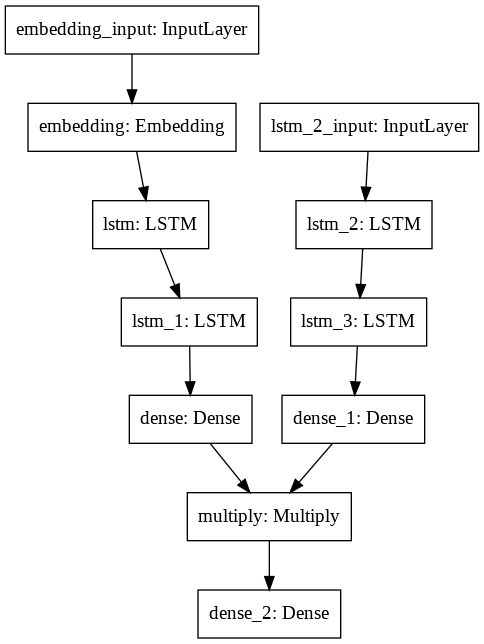

In [46]:
# Draw the model
from keras.utils import plot_model
plot_model(model)

### Training

In [47]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy','mae'])

In [48]:
# initializer callbacks - for tensorboard graphs and early stopping 
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [49]:
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val), callbacks=[tensorboard_callback, es])

Epoch 1/20
1217/1217 [==============================] - 55s 36ms/step - loss: 6.0577 - accuracy: 0.1297 - mae: 2.6587e-04 - val_loss: 5.2620 - val_accuracy: 0.1781 - val_mae: 2.5203e-04
Epoch 2/20
1217/1217 [==============================] - 41s 34ms/step - loss: 5.0459 - accuracy: 0.1826 - mae: 2.5287e-04 - val_loss: 5.0145 - val_accuracy: 0.2012 - val_mae: 2.5173e-04
Epoch 3/20
1217/1217 [==============================] - 42s 34ms/step - loss: 4.7051 - accuracy: 0.2059 - mae: 2.4652e-04 - val_loss: 4.9182 - val_accuracy: 0.2124 - val_mae: 2.4512e-04
Epoch 4/20
1217/1217 [==============================] - 42s 35ms/step - loss: 4.4640 - accuracy: 0.2233 - mae: 2.4174e-04 - val_loss: 4.8444 - val_accuracy: 0.2264 - val_mae: 2.4366e-04
Epoch 5/20
1217/1217 [==============================] - 41s 34ms/step - loss: 4.2436 - accuracy: 0.2437 - mae: 2.3654e-04 - val_loss: 4.8476 - val_accuracy: 0.2406 - val_mae: 2.4078e-04
Epoch 6/20
1217/1217 [==============================] - 41s 34ms/step 

In [ ]:
# show tensorboard graphs - removed graphs because take a lot of disk space
%tensorboard --logdir logs/fit

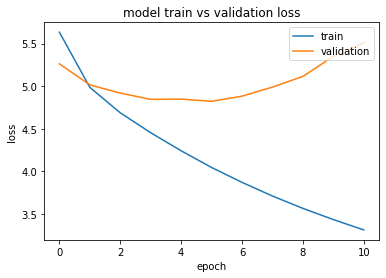

In [51]:
# show validation/train loss graph usin matplotlib
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

### Testing

In [52]:
def get_relational_beats(beats_list, beats_seq_length, curr_lyrics_ind, n_total_words_generating):
  """
  Returns list of relational beats according to the song's length
  """
  beats_len = len(beats_list)
  rel_start_ind = int((curr_lyrics_ind / n_total_words_generating) * beats_len)
  rel_start_ind = rel_start_ind if rel_start_ind + beats_seq_length < beats_len else beats_len-beats_seq_length
  rel_end_ind = rel_start_ind + beats_seq_length
  rel_beats_sequence = beats_list[rel_start_ind:rel_end_ind]
  rel_beats_sequence = np.reshape(rel_beats_sequence, (1, beats_seq_length))
  return rel_beats_sequence

In [53]:
def generate_lyrics_from_seed_lyrics_and_melody(model, tokenizer, text_seq_length, beats_seq_length, seed_text, melody_beats_list, n_words):
  """
  Run prediction of a new song. returns the generated text.
  """

  text=seed_text
  for i in range(n_words):
    encoded = tokenizer.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=text_seq_length, truncating='pre')

    beats_curr_seq = get_relational_beats(melody_beats_list, beats_seq_length, i, n_words)

    model_input = [np.asarray(encoded), np.asarray(beats_curr_seq)]

    prediction = model.predict(model_input)
    predicted_index = np.random.choice(vocab_size, p=prediction[0])
    predicted_word = tokenizer.index_word[predicted_index]
    text += " " + predicted_word
  
  return text

In [54]:
print("generate_lyrics from word and song melody")
seed_texts = ['tonight', 'everybody', 'love']

for index, song in test_df.iterrows():
  seed_text = song.lyrics.split()[0]
  print(f"Generated lyrics for song number {index}, while The first word of the song is '{seed_text}':\n")
  generated_song = generate_lyrics_from_seed_lyrics_and_melody(model, tokenizer, lyrics_seq_length-1, beats_seq_length, seed_text, song.beats, 600)
  print(generated_song)
  
  for i in range(0,3,1):
    print(f"Generated lyrics for song number {index}, while the seed text is '{seed_texts[i]}':\n")
    generated_song = generate_lyrics_from_seed_lyrics_and_melody(model, tokenizer, lyrics_seq_length-1, beats_seq_length, seed_texts[i], song.beats, 600)
    print(generated_song)


generate_lyrics from word and song melody
Generated lyrics for song number 0, while The first word of the song is 'close':

close & touch that a school dress roll & more bells 'ers coladas & i just can't even go all now what the news we're living & just tell me your soul was killing me & got your lover's man inside me & i said i love you oh 'cause goodbye no more than more & but what can i go tell & like the night oh whey oh & one out highway listen to you & the wonders of my life & was the only time is all right & you're feelin' there & and i will walk away & yes he likes your lonely life again & there's nothing true if i got no gonna bother treat me but i walked straight back to that lift & bite a wintry ei since change of your homies & the spirit's and dope boy is stereo & i'm losing my tires through on & someday when you're together without me & to hear what's soon i love you oh definitely & what's every living for the girl & whatever you wanna be real & waiting like about & i'll g

# Reset Data

In [55]:
# reset arrays in order to run the second version immediately  
del (X_train)
del (X_val)
del (y_train)
del (y_val)
del (model)

# Midi version 2

### Midi data vectors

In [56]:
def get_notes(inst):
  """
  returns all notes of the given instrument
  """
  notes = []
  for instrument in inst:
    for note in instrument.notes:
      notes.append(note.pitch)
  return set(notes)

In [57]:
def get_vector(list_to_vector):
  """
  returns hot vector of size 128 - each value represent note or instrument.
  value of 1 meaning song contains this instrument/note 
  """
  vector = np.zeros(128)
  for index in list_to_vector:
    vector[index] = 1
  return vector

In [58]:
def get_midi_vectors(df):
  """
  Returns midi vectors for each one of the songs in the given dataframe.
  """
  midi_vectors = []
  midi_keys = midi_data.keys()

  for index, row in df.iterrows():
    singer = row.singer.strip()
    song_name = row.song_name.strip()
    if (singer, song_name) in midi_keys:
      instruments = midi_data[(singer, song_name)].instruments
      song_instruments = set([ins.program for ins in instruments])
      song_notes = get_notes(instruments)
      
      # transform to vectors
      song_instruments_vector = get_vector(song_instruments)
      song_notes_vector = get_vector(song_notes)
      midi_vector = np.concatenate((song_instruments_vector, song_notes_vector))

      # add to midi_vectors
      midi_vectors.append(midi_vector)

    # songs without midi file
    else:
      print(f"Song without midi file: {singer}, {song_name}")
      midi_vector = np.zeros(256)

      # add to midi_vectors
      midi_vectors.append(midi_vector)
    
  return midi_vectors

In [59]:
# run and get midi_vectors
midi_vectors_train = get_midi_vectors(train_df)
midi_vectors_test = get_midi_vectors(test_df)

In [60]:
len(midi_vectors_train)

593

### Text sequences 

In [61]:
def get_sequences(sequences_texts, sequence_len):
  """
  Returns x and y train and validation sets.
  """
  x = []
  y = []

  # for each song, create sequences of sequence_len till the end of the song and concatenate each sequence with the right midi vector of the song.
  # apped this vector to x list, and the append the last word (prediction word) to y list. 
  for index, sample in enumerate(sequences_texts):
    for i in range(0, len(sample) - sequence_len, 1):
      x.append(np.concatenate((sample[i:i+sequence_len], midi_vectors_train[index])))
      y.append(sample[i+sequence_len])
  
  # split train and validation sets
  X_train, X_val, y_train, y_val = split_train_test(x,y)

  # transform to np array for model's input
  X_train = np.array(X_train)
  X_val = np.array(X_val)

  # split X into two lists of lyrics and midi lists
  X_train_lyrics = X_train[:, :sequence_len]
  X_train_midi = X_train[:, sequence_len:]
  X_train = [X_train_lyrics, X_train_midi]

  X_val_lyrics = X_val[:, :sequence_len]
  X_val_midi = X_val[:, sequence_len:]
  X_val = [X_val_lyrics, X_val_midi]

  # transform y into one hot vectors
  y_train = to_categorical(y_train, num_classes=vocab_size)
  y_val = to_categorical(y_val, num_classes=vocab_size) 

  return X_train, X_val, y_train, y_val

In [62]:
sequence_len = 10
X_train, X_val, y_train, y_val = get_sequences(sequences_texts, sequence_len)

### Build Model - Midi version 2

In [63]:
# add midi files - v1
def build_model(lyrics_vector_size, midi_vector_size, embedding_matrix, embedding_dim, vocab_size):
  input_layer_lyrics = Input(shape=(lyrics_vector_size), name="lyrics_input_layer")
  input_layer_midi = Input(shape=(midi_vector_size), name="midi_input_layer")

  embedding_output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True)(input_layer_lyrics)
  
  # repeat midi vector in order to concatente this vector to all word vectors of the given sequence
  reshaped_midi_input = keras.layers.RepeatVector(input_layer_lyrics.shape[1])(input_layer_midi)
  conc_output = keras.layers.Concatenate()([embedding_output, reshaped_midi_input])

  lstm_out = LSTM(256)(conc_output)
  drop_out = Dropout(0.1)(lstm_out)

  output_layer = Dense(activation='softmax', units=vocab_size)(drop_out)
  model = Model([input_layer_lyrics, input_layer_midi], output_layer, name="model")
  model.summary()
  
  return model

In [65]:
lyrics_vector_size = X_train[0][0].shape
midi_vector_size = X_train[1][0].shape

In [68]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [69]:
model = build_model(lyrics_vector_size, midi_vector_size, embedding_matrix, 300, vocab_size)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lyrics_input_layer (InputLayer) [(None, 10)]         0                                            
__________________________________________________________________________________________________
midi_input_layer (InputLayer)   [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 300)      2180700     lyrics_input_layer[0][0]         
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 10, 256)      0           midi_input_layer[0][0]           
______________________________________________________________________________________________

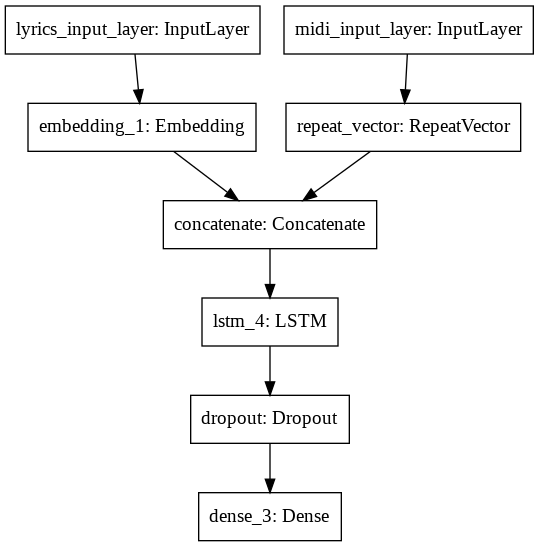

In [70]:
# Draw the model
from keras.utils import plot_model
plot_model(model)

### Training

In [71]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy','mae'])

In [72]:
# initializer callbacks - for tensorboard graphs and early stopping 
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [73]:
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val), callbacks=[tensorboard_callback, es])

Epoch 1/20
1217/1217 [==============================] - 43s 34ms/step - loss: 5.8224 - accuracy: 0.1511 - mae: 2.6303e-04 - val_loss: 4.8766 - val_accuracy: 0.2030 - val_mae: 2.5017e-04
Epoch 2/20
1217/1217 [==============================] - 39s 32ms/step - loss: 4.6452 - accuracy: 0.2151 - mae: 2.4795e-04 - val_loss: 4.4878 - val_accuracy: 0.2465 - val_mae: 2.4310e-04
Epoch 3/20
1217/1217 [==============================] - 40s 33ms/step - loss: 4.1149 - accuracy: 0.2651 - mae: 2.3859e-04 - val_loss: 4.2117 - val_accuracy: 0.2860 - val_mae: 2.3531e-04
Epoch 4/20
1217/1217 [==============================] - 40s 32ms/step - loss: 3.6474 - accuracy: 0.3155 - mae: 2.2883e-04 - val_loss: 4.0323 - val_accuracy: 0.3154 - val_mae: 2.2783e-04
Epoch 5/20
1217/1217 [==============================] - 40s 33ms/step - loss: 3.2427 - accuracy: 0.3646 - mae: 2.1873e-04 - val_loss: 3.9165 - val_accuracy: 0.3395 - val_mae: 2.1951e-04
Epoch 6/20
1217/1217 [==============================] - 40s 33ms/step 

In [ ]:
# shows TensorBoard graphs
%tensorboard --logdir logs/fit

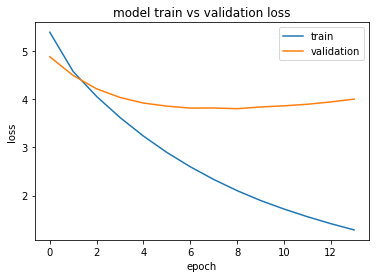

In [75]:
# plot train/validation loss per epoch using matplotlib
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

### Testing

In [76]:
def generate_lyrics(seed_text, midi_vector, lyrics_vector_size):
  """

  """
  predicted_word = seed_text
  text = seed_text
  midi_vector = np.reshape(midi_vector,(1, midi_vector.shape[0]))

  # Generate words till eof or 1000 words
  while predicted_word != 'eof' and len(text.split(" ")) < 1000:
    token_list = tokenizer.texts_to_sequences([text])[0] # tokenize text
    token_list = pad_sequences([token_list], maxlen=lyrics_vector_size, padding='pre') # take only the last lyrics_vector_size words

    # prepare model input
    token_list = np.array(token_list)
    model_input = [token_list, midi_vector] 
    
    prediction = model.predict(model_input, verbose=0)

    # sample randomly according to predcition distributions
    predicted_index = np.random.choice(vocab_size, p=prediction[0])
    # get the predicted word from dictionary
    predicted_word = tokenizer.index_word[predicted_index]
    # append word to the end of the generated text
    text += " " + predicted_word
  return text

In [77]:
def testing(seed_texts, lyrics_vector_size):
  for index, song in test_df.iterrows():
    seed_text = song.lyrics.split()[0]
    print(f"Generated lyrics for song number {index}, while The first word of the song is '{seed_text}':")
    generated_song = generate_lyrics(seed_text, midi_vectors_test[index], lyrics_vector_size)
    print(generated_song + "\n")
    
    for i in range(0,3,1):
      print(f"Generated lyrics for song number {index}, while the seed text is '{seed_texts[i]}':")
      generated_song = generate_lyrics(seed_texts[i], midi_vectors_test[index], lyrics_vector_size)
      print(generated_song + "\n")

In [78]:
seed_texts = ['tonight', 'everybody', 'love']

testing(seed_texts, lyrics_vector_size[0])

Generated lyrics for song number 0, while The first word of the song is 'close':
close & hey you're not the way that i've got such a plan & please start to the bedpost & i want more or just the way you say & 'cause i'm in love baby & if you are my baby ever have no other way & and let me still go ahead with the right i'd do & if you want my way to take your sweet love with you & i know that never said you'd really be & how you know what it's time & but it doesn't know what it wasn't so very & so shake still on fall on more and then you put me down and 'cause it alone i don't think someone & what would just be right & or if i could be happy then maybe we'll be there & i go time and the way i sleep through all through the time & and i'm in the son it's a sweet and by it's the only the way & your out is the tender is the way & when you've gotta be around & oh yeah & so i don't know what's there is a girl in my heart & so i want to find myself a way to find & because i will show you just c

# Temp sections

## Word2Vec

In [ ]:
!gdown --id 0B7XkCwpI5KDYNlNUTTlSS21pQmM

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/GoogleNews-vectors-negative300.bin.gz
1.65GB [00:12, 130MB/s]


In [ ]:
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
embedding_dim=300
vocabulary_size=len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
missing_words = []
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
      missing_words.append(word)
      embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), embedding_dim)

# del(word_vectors)

In [ ]:
len(missing_words)

348